# Pneumonia Identification from X-rays

We try to solve the problem of detecting pneumonia from xrays 

Data available at https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?datasetId=17810

#### Import the necessary libraries 

In [2]:
import numpy as np 
import pandas as pd 
import random
import cv2
import copy
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import tqdm

%matplotlib inline 

In [3]:
torch.cuda.is_available()

True

In [4]:
# Set the directory of the data 

data_dir = 'chest_xray'


train_pneumonia_data = os.listdir(data_dir + "/train/PNEUMONIA")

train_normal_data = os.listdir(data_dir + "/train/NORMAL")


In [5]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['.DS_Store', 'test', 'train', 'val']
['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [13]:
# Import the data from directory 

train_dataset = ImageFolder(data_dir+'/train', 
                      transform=transforms.Compose([
                          transforms.Resize([224,224]),
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomRotation(10),
                          transforms.RandomGrayscale(),
                          transforms.RandomAffine(translate=(0.05,0.05), degrees=0),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                          std=[0.5, 0.5, 0.5] ,inplace=True)
                       ])
                 )
test_dataset = ImageFolder(data_dir+'/test', 
                      transform=transforms.Compose([
                          transforms.Resize([224,224]),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                          std=[0.5, 0.5, 0.5] ,inplace=True)
                       ])
                 )

In [14]:

trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2) 
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [8]:
len(train_dataset)

5216

In [11]:
test_dataset.classes

['NORMAL', 'PNEUMONIA']

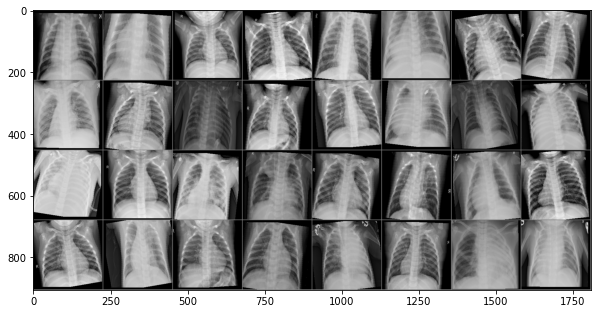

In [15]:
def imshow(img):
    plt.figure(figsize=(10,10))
    img = img/2 +0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [30]:
# Import pretrained resnet152 
resnet = torchvision.models.resnet152(pretrained=True)

In [31]:
# Turn off updating all the layes 
for param in resnet.parameters():
    param.requires_grad = False

In [53]:
# Set the necessary alterations in order to fit our requirements 
# Change the output to 1 since we have binary classification problem  
resnet.fc = nn.Linear(2048, 2)

In [54]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
resnet = resnet.cuda()

In [56]:
resnet(images.cuda()).shape

torch.Size([32, 2])

In [57]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

In [58]:
def quality(resnet):
    correct = 0
    total =0 
    with torch.no_grad():
        for data in testloader:
            images, labels = data 
            images, labels = images.cuda(), labels.cuda()
            outputs = resnet(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on test images: %d %%' % (100*correct/total))


def train_network(resnet, n_epochs=10):
    losses =[]
    for epoch in range(n_epochs): 
        running_loss = 0.0
        for i, data in enumerate(tqdm.tqdm(trainloader)): 
            # get the inputs 
            images, labels = data 
            images, labels = images.cuda(), labels.cuda()
            
            # zero the parameter gradients 
            optimizer.zero_grad()
            
            # forward + backward + optimize 
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            loss.backward() # back propagation 
            optimizer.step() # update weights 
            
            # print statistics 
            running_loss += loss.item()
            losses.append(loss.item())
            
        print("[%d, %5d] loss: %.3f" %
              (epoch +1, i+1, running_loss/2000))
        running_loss = 0.0 

        quality(resnet)
    
    plt.plot(losses, 'b')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

100%|██████████| 163/163 [00:32<00:00,  5.00it/s]


[1,   163] loss: 0.015
Accuracy of the network on test images: 59 %


100%|██████████| 163/163 [00:33<00:00,  4.83it/s]


[2,   163] loss: 0.013
Accuracy of the network on test images: 59 %


100%|██████████| 163/163 [00:33<00:00,  4.85it/s]


[3,   163] loss: 0.012
Accuracy of the network on test images: 61 %


100%|██████████| 163/163 [00:32<00:00,  5.00it/s]


[4,   163] loss: 0.012
Accuracy of the network on test images: 62 %


100%|██████████| 163/163 [00:32<00:00,  4.96it/s]


[5,   163] loss: 0.013
Accuracy of the network on test images: 60 %


100%|██████████| 163/163 [00:32<00:00,  5.02it/s]


[6,   163] loss: 0.011
Accuracy of the network on test images: 62 %


100%|██████████| 163/163 [00:32<00:00,  5.05it/s]


[7,   163] loss: 0.012
Accuracy of the network on test images: 61 %


100%|██████████| 163/163 [00:32<00:00,  5.02it/s]


[8,   163] loss: 0.011
Accuracy of the network on test images: 60 %


100%|██████████| 163/163 [00:33<00:00,  4.92it/s]


[9,   163] loss: 0.013
Accuracy of the network on test images: 61 %


100%|██████████| 163/163 [00:33<00:00,  4.91it/s]


[10,   163] loss: 0.012
Accuracy of the network on test images: 62 %


100%|██████████| 163/163 [00:33<00:00,  4.93it/s]


[11,   163] loss: 0.011
Accuracy of the network on test images: 59 %


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


[12,   163] loss: 0.011
Accuracy of the network on test images: 61 %


100%|██████████| 163/163 [00:33<00:00,  4.88it/s]


[13,   163] loss: 0.011
Accuracy of the network on test images: 62 %


100%|██████████| 163/163 [00:33<00:00,  4.87it/s]


[14,   163] loss: 0.012
Accuracy of the network on test images: 62 %


100%|██████████| 163/163 [00:33<00:00,  4.88it/s]


[15,   163] loss: 0.011
Accuracy of the network on test images: 62 %


100%|██████████| 163/163 [00:32<00:00,  4.97it/s]


[16,   163] loss: 0.011
Accuracy of the network on test images: 59 %


100%|██████████| 163/163 [00:35<00:00,  4.60it/s]


[17,   163] loss: 0.011
Accuracy of the network on test images: 61 %


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


[18,   163] loss: 0.011
Accuracy of the network on test images: 61 %


100%|██████████| 163/163 [00:33<00:00,  4.90it/s]


[19,   163] loss: 0.011
Accuracy of the network on test images: 60 %


100%|██████████| 163/163 [00:33<00:00,  4.89it/s]


[20,   163] loss: 0.011
Accuracy of the network on test images: 63 %


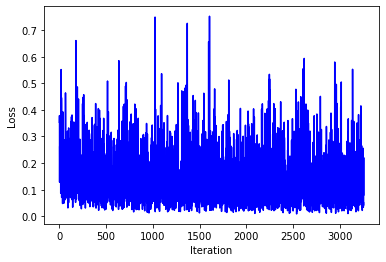

In [60]:
train_network(resnet, n_epochs=20)